In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/Users/willwolf/Documents/willwolf/dotify


In [3]:
# delete this eventually

import os

os.environ['SQLALCHEMY_DATABASE_URI'] = os.environ['DIGITAL_OCEAN_SQLALCHEMY_DATABASE_URI']

In [14]:
from collections import namedtuple
from copy import deepcopy
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sqlalchemy import create_engine

from dotify.config import DevelopmentConfig as Config
from dotify.recommendation.implicit_mf.ratings_matrix import RatingsMatrix
from dotify.recommendation.implicit_mf.implicit_mf import ImplicitMF
from dotify.resources.countries import countries as countries_lookup

ENGINE = create_engine(Config.SQLALCHEMY_DATABASE_URI)

%matplotlib inline

In [5]:
ratings_matrix = RatingsMatrix(n_top_songs=10000, eps=1e3)

In [6]:
ratings_matrix.R_ui.head()

song_id,5552,5553,5555,5556,5557,5558,5560,5562,5565,5582,...,33062,33063,33064,33065,33066,33067,33068,33069,33070,33071
country_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.000000,0.0,4.045469,0.0,0.0,0.0,3.643437,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,2.587463,0.000000,0.0,0.000000,0.0,2.814270,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000000,2.961865,0.0,2.859512,0.0,3.175760,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,1.138153,0.961264,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# split into train, test sets

In [ ]:
(ratings_matrix.R_ui > 0).sum(axis=1).hist()

In [ ]:
np.percentile((ratings_matrix.R_ui > 0).sum(axis=1), 25)

In [ ]:
more_than_50_ratings_mask = (ratings_matrix.R_ui > 0).sum(axis=1) > 50

In [ ]:
FRACTION_TO_DROP = .2
TRAINING_MATRIX = ratings_matrix
VALIDATION_MATRIX = deepcopy(TRAINING_MATRIX)
VALIDATION_MATRIX.R_ui = pd.DataFrame(0., index=TRAINING_MATRIX.R_ui.index, columns=TRAINING_MATRIX.R_ui.columns)

for country_id, ratings in TRAINING_MATRIX.R_ui[more_than_50_ratings_mask].iterrows():
    rated_songs_mask = TRAINING_MATRIX.R_ui.ix[country_id] > 0
    rated_songs = TRAINING_MATRIX.R_ui.ix[country_id][rated_songs_mask].index.tolist()
    nb_songs_to_drop = int( len(rated_songs)*FRACTION_TO_DROP )
    songs_to_drop = set( random.sample(rated_songs, nb_songs_to_drop) )
    
    VALIDATION_MATRIX.R_ui.ix[country_id][songs_to_drop] = TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop]
    TRAINING_MATRIX.R_ui.ix[country_id][songs_to_drop] = 0.

# evaluate

In [ ]:
class ExpectedPercentileRankingsEvaluator:
    
    def __init__(self, training_matrix, validation_matrix, predicted_preferences):
        self.training_matrix = training_matrix
        self.validation_matrix = validation_matrix
        self.predicted_preferences = predicted_preferences
        self.expected_percentile_rankings_train = []
        self.expected_percentile_rankings_validation = []
        
    def run(self):
        self._evaluate_train()
        self._evaluate_validation()

    def _evaluate_train(self):
        self.expected_percentile_rankings_train = self._evaluate(matrix=self.training_matrix)
        
    def _evaluate_validation(self):
        self.expected_percentile_rankings_validation = self._evaluate(matrix=self.validation_matrix)
        
    def _evaluate(self, matrix):
        expected_percentile_rankings = []
        for country_id, preferences in predicted_preferences[more_than_50_ratings_mask].iterrows():
            predictions = pd.DataFrame({
                'predicted_preference': preferences.sort_values(ascending=False),
                'rank': np.arange( len(preferences) ),
                'percentile_rank': np.arange( len(preferences) ) / len(preferences)
            })
            ground_truth = matrix.R_ui.ix[country_id][ matrix.R_ui.ix[country_id] > 0 ]
            numerator = (ground_truth * predictions['percentile_rank'][ground_truth.index]).sum()
            denominator = ground_truth.sum()
            expected_percentile_rankings.append( numerator / denominator )

        return expected_percentile_rankings
    
# with a list of expected ranking values, we could compute the entropy in this distribution

In [111]:
# let's make a visualization out of this eventually

grid_search_results = {result(alpha=0.1, lmbda=0.1): {'train': 0.032407390666058453,
  
'validation': 0.31665039472192003},
 result(alpha=0.1, lmbda=1.0): {
'train': 0.032059217808275829,
  
'validation': 0.24402526519871739},
 result(alpha=0.1, lmbda=10.0): {
'train': 0.045523277235144662,
  
'validation': 0.16606585548569086},
 result(alpha=0.1, lmbda=100.0): {
'train': 0.13769244526151611,
  
'validation': 0.21052119237046174},
 result(alpha=1.0, lmbda=0.1): {
'train': 0.031713329010977634,
  
'validation': 0.28160772806600787},
 result(alpha=1.0, lmbda=1.0): {
'train': 0.031724480161575093,
  
'validation': 0.26509705526720212},
 result(alpha=1.0, lmbda=10.0): {
'train': 0.032602322510421271,
  
'validation': 0.17842803591797687},
 result(alpha=1.0, lmbda=100.0): {
'train': 0.13826569594315918,
  
'validation': 0.21545848705024651},
 result(alpha=10.0, lmbda=0.1): {
'train': 0.031434247195100157,
  
'validation': 0.2039108951054108},
 result(alpha=10.0, lmbda=1.0): {
'train': 0.031299578843675971,
  
'validation': 0.2277074749329171},
 result(alpha=10.0, lmbda=10.0): {
'train': 0.031127684231213384,
  
'validation': 0.1898255168476902},
 result(alpha=10.0, lmbda=100.0): {
'train': 0.051315700721965694,
  
'validation': 0.18669700464271369},
 result(alpha=100.0, lmbda=0.1): {
'train': 0.032712876751746674,
  
'validation': 0.18575014195665038},
 result(alpha=100.0, lmbda=1.0): {
'train': 0.032677287037866626,
  
'validation': 0.19425985589739683},
 result(alpha=100.0, lmbda=10.0): {
'train': 0.031940565004912803,
  
'validation': 0.20191916342002017},
 result(alpha=100.0, lmbda=100.0): {
'train': 0.032361700905882793,
  
'validation': 0.18102583299733102}}

In [110]:
F = 30
grid_search_results = {}
result = namedtuple('Result', 'alpha lmbda')

# for alpha in [1e-1, 1e0, 1e1, 1e2]:
#     for lmbda in [1e-1, 1e0, 1e1, 1e2]:
#         implicit_mf = ImplicitMF(ratings_matrix=TRAINING_MATRIX, f=F, alpha=alpha, lmbda=lmbda)
#         implicit_mf.run()
#         predicted_preferences = implicit_mf.country_vectors.vectors.dot( implicit_mf.song_vectors.vectors.T )
        
#         evaluator = ExpectedPercentileRankingsEvaluator(
#             training_matrix=TRAINING_MATRIX,
#             validation_matrix=VALIDATION_MATRIX,
#             predicted_preferences=predicted_preferences
#         )
#         evaluator.run()
#         grid_search_results[result(alpha=alpha, lmbda=lmbda)] = {
#             'train': np.mean(evaluator.expected_percentile_rankings_train),
#             'validation': np.mean(evaluator.expected_percentile_rankings_validation)
#         }
#         print(grid_search_results)

In [112]:
best_params = min(grid_search_results, key=lambda key: grid_search_results.get(key)['validation'])

In [ ]:
# train a final model

In [113]:
implicit_mf = ImplicitMF(ratings_matrix=ratings_matrix, f=F, alpha=best_params.alpha, lmbda=best_params.lmbda)
implicit_mf.run()

0
1
2
3
4
5
6
7
8
9


# save stuff we care about from the final implicit mf run

In [114]:
# implicit_mf.country_vectors.vectors.to_csv('data/country_vectors.csv')
# implicit_mf.song_vectors.vectors.to_csv('data/song_vectors.csv')
# implicit_mf.country_vectors.vectors = pd.read_csv('data/country_vectors.csv', index_col=['country_id'])
# implicit_mf.song_vectors.vectors = pd.read_csv('data/song_vectors.csv', index_col=['song_id'])

## Visualize

In [115]:
country_vectors_df = implicit_mf.country_vectors.vectors

In [116]:
# change countries index form id to name

In [117]:
sns.set(style="white")

In [118]:
country_id_to_name = {countries_lookup[name]['id']: name for name in countries_lookup}
country_ids = country_vectors_df.index
country_names = pd.Index([country_id_to_name[c_id] for c_id in country_ids], name='country_name')
country_vectors_df.index = country_names

In [119]:
def plot_cosine_similarities(country_vectors_df):

    # compute the cosine similarity matrix
    similarities_df = pd.DataFrame(
        data=cosine_similarity(country_vectors_df),
        index=country_vectors_df.index,
        columns=country_vectors_df.index
    )
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(similarities_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(21, 21))

    # generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(similarities_df, mask=mask, cmap=cmap, vmax=.5,
                square=True, xticklabels=True, yticklabels=True,
                linewidths=1, cbar_kws={"shrink": .5}, ax=ax)

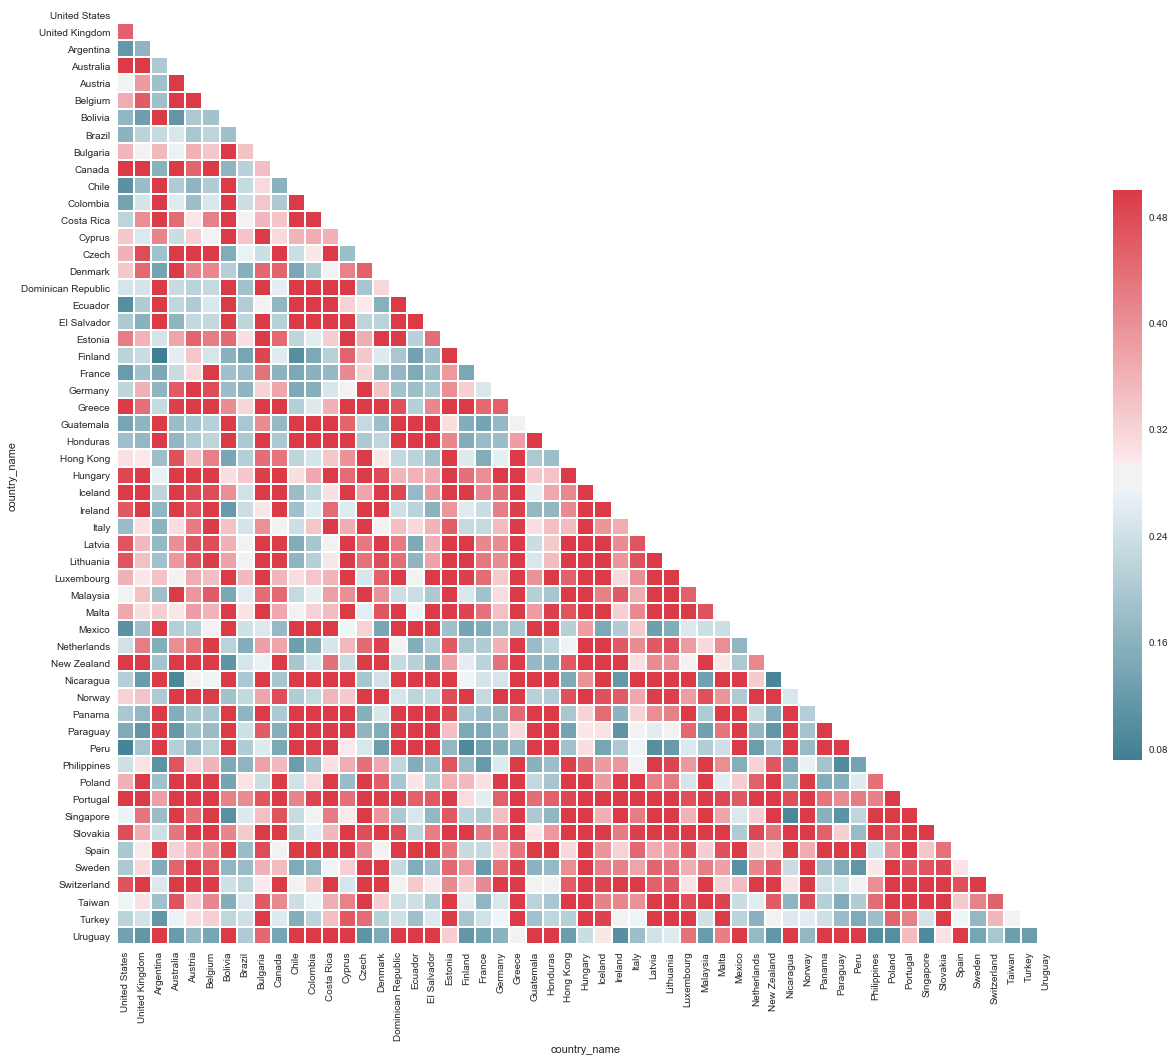

In [120]:
plot_cosine_similarities(country_vectors_df)

# tsne

In [121]:
from matplotlib import pylab
from sklearn.manifold import TSNE

In [122]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [123]:
country_embeddings = pd.DataFrame(
    data=tsne.fit_transform(country_vectors_df),
    index=country_vectors_df.index,
    columns=['dim_1', 'dim_2']
)

In [124]:
def plot_tsne_embeddings(country_embeddings):

    pylab.figure(figsize=(15,15))

    for country_name, country_embedding in country_embeddings.iterrows():
        dim_1, dim_2 = country_embedding
        pylab.scatter(dim_1, dim_2)
        pylab.annotate(country_name, xy=(dim_1, dim_2), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

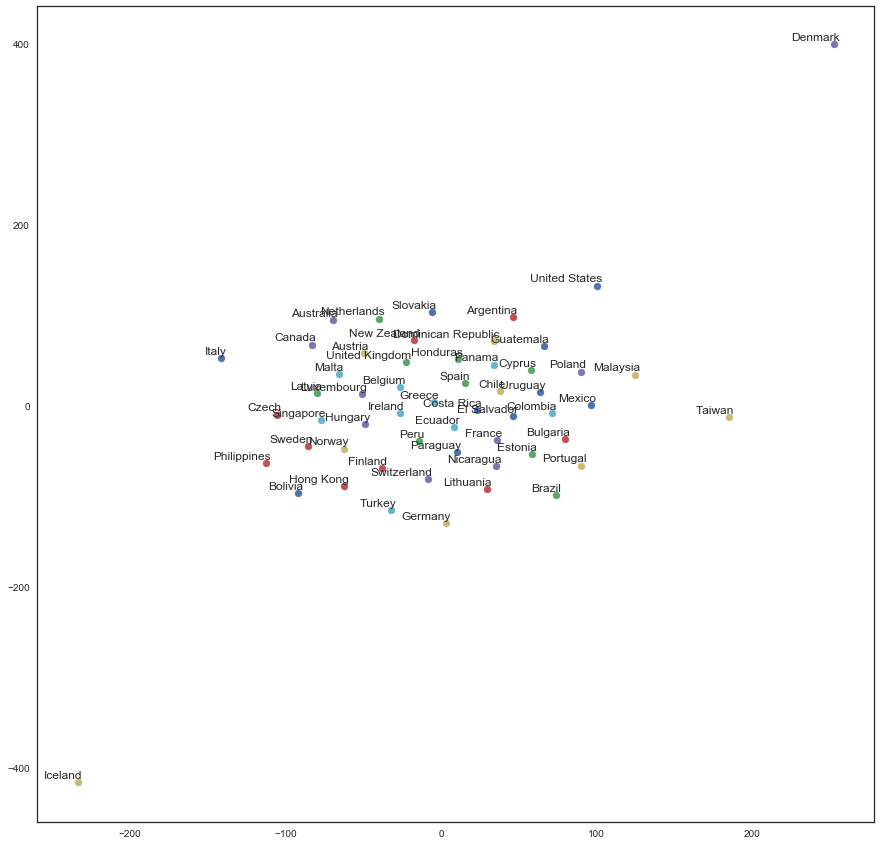

In [125]:
plot_tsne_embeddings(country_embeddings)

## Inspect arithmetic combinations

In [126]:
SONG_METADATA_QUERY = """
    SELECT 
        songs.title as song_title, 
        songs.artist as song_artist,
        songs.id as song_id
    FROM songs
"""

song_metadata_df = pd.read_sql(SONG_METADATA_QUERY, ENGINE, index_col=['song_id'])

In [127]:
song_vectors_df = song_metadata_df.join(implicit_mf.song_vectors.vectors, how='inner')\
    .set_index(['song_title', 'song_artist'])

In [128]:
country_vec = country_vectors_df.ix['United States']

In [141]:
pd.set_option('display.max_colwidth', 100)

In [143]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Shape of You,Ed Sheeran,0.947265
1,It Ain't Me (with Selena Gomez),Kygo,0.943512
2,Something Just Like This,The Chainsmokers,0.942639
3,That's What I Like,Bruno Mars,0.941953
4,Passionfruit,Drake,0.940638
5,Paris,The Chainsmokers,0.940558
6,"I Don’t Wanna Live Forever (Fifty Shades Darker) - From ""Fifty Shades Darker (Original Motion Pi...",ZAYN,0.940260
7,Stay (with Alessia Cara),Zedd,0.938271
8,Galway Girl,Ed Sheeran,0.937455
9,Symphony (feat. Zara Larsson),Clean Bandit,0.936264


In [144]:
country_vec = country_vectors_df.ix['Colombia']

In [145]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Don't Wanna Know,Maroon 5,0.974983
1,Let Me Love You,DJ Snake,0.973869
2,Closer,The Chainsmokers,0.972029
3,Despacito (Featuring Daddy Yankee),Luis Fonsi,0.971427
4,Shape of You,Ed Sheeran,0.968926
5,I Took A Pill In Ibiza - Seeb Remix,Mike Posner,0.968618
6,I Feel It Coming,The Weeknd,0.965848
7,In the Name of Love,Martin Garrix,0.965257
8,It Ain't Me (with Selena Gomez),Kygo,0.962449
9,Perfect,Ed Sheeran,0.962377


In [146]:
country_vec = country_vectors_df.ix['Panama']

In [147]:
song_vectors_df.dot(country_vec).sort_values(ascending=False).reset_index().head(10)

,song_title,song_artist,0
0,Shape of You,Ed Sheeran,0.849492
1,It Ain't Me (with Selena Gomez),Kygo,0.841565
2,Something Just Like This,The Chainsmokers,0.840284
3,That's What I Like,Bruno Mars,0.839483
4,Paris,The Chainsmokers,0.838639
5,"I Don’t Wanna Live Forever (Fifty Shades Darker) - From ""Fifty Shades Darker (Original Motion Pi...",ZAYN,0.838564
6,Scared to Be Lonely,Martin Garrix,0.826302
7,Passionfruit,Drake,0.825950
8,Stay (with Alessia Cara),Zedd,0.825143
9,Cold,Maroon 5,0.824545
